In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

### Hyperparameters

In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=1

### Load Dataset

In [3]:
#Load Dataset
data_variance, train_set, val_set, val_len = load_FloorPlan()
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

data shape: torch.Size([1, 56, 56]), dataset size: 2806, data variance: 0.00716308131814003


### Load Best or Train

In [4]:
vqvae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr, amsgrad=False)
train_res_recon_error = []
test_res_recon_error = []
start_epoch = 0
end_epoch = 150
best_loss = 2

##### load best checkpoint

In [5]:
vqvae.load_state_dict(torch.load("checkpoint/best/95-vqae-0.21704871313912527.pt"))
# optimizer.load_state_dict(torch.load("checkpoint/95-adam-0.21704871313912527.pt"))

with open("checkpoint/best/95-vqae_train-0.21704871313912527.json") as json_file:
    train_res_recon_error = json.load(json_file)
with open("checkpoint/best/95-vqae_test-0.21704871313912527.json") as json_file:
    test_res_recon_error = json.load(json_file)
    
start_epoch = 96
end_epoch = 150
best_loss = 0.21704871313912527

##### train

In [17]:
for epoch in range(start_epoch, end_epoch+1):
    with tqdm(train_loader, unit="batch") as tepoch:
        vqvae.train()
        for data in tepoch:
            data_no_noise = data.to(device)
            optimizer.zero_grad()

            if noise:
                data = add_noise(data_no_noise, noise_weight=noise_weight)
            else:
                data = data_no_noise
            vq_loss, data_recon, perplexity = vqvae(data_no_noise)
            recon_error = F.mse_loss(data_recon, data_no_noise) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()
            tepoch.set_postfix(loss=float(loss.detach().cpu()))
            train_res_recon_error.append(recon_error.item())

    avg_loss = 0
    vqvae.eval()
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)

            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error.item() * batch_size

            avg_loss += loss / val_len
            test_res_recon_error.append(loss)

    if epoch%5==0 and avg_loss<best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        torch.save(vqvae.state_dict(), f"checkpoint/{best_epoch}-vqae-{best_loss}.pt")
        torch.save(optimizer.state_dict(), f"checkpoint/{best_epoch}-adam-{best_loss}.pt")
        with open(f"checkpoint/{best_epoch}-vqae_train-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(train_res_recon_error, json_file, ensure_ascii = False)
        with open(f"checkpoint/{best_epoch}-vqae_test-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(test_res_recon_error, json_file, ensure_ascii = False)

    print(f'Validation Loss: {avg_loss}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29batch/s, loss=52.7]


Validation Loss: 6.99290793282645


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.35batch/s, loss=46.1]


Validation Loss: 3.0824127197265625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.22batch/s, loss=16.2]


Validation Loss: 1.4688447679792132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.22batch/s, loss=11.3]


Validation Loss: 1.0167890276227678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.47batch/s, loss=8.7]


Validation Loss: 0.9466684068952289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.42batch/s, loss=6.78]


Validation Loss: 0.7789778573172432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.38batch/s, loss=5.68]


Validation Loss: 0.7125349044799805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.40batch/s, loss=4.27]


Validation Loss: 0.6823761667524065


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.52batch/s, loss=3.28]


Validation Loss: 0.7393663951328823


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.49batch/s, loss=2.7]


Validation Loss: 0.6793216432843889


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.37batch/s, loss=2.24]


Validation Loss: 0.666020815713065


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.36batch/s, loss=1.97]


Validation Loss: 0.6221864700317382


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31batch/s, loss=1.72]


Validation Loss: 0.6020877701895577


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.37batch/s, loss=1.35]


Validation Loss: 0.5843750272478376


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.41batch/s, loss=1.21]


Validation Loss: 0.565425968170166


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.50batch/s, loss=1.08]


Validation Loss: 0.5490438597542899


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.39batch/s, loss=0.956]


Validation Loss: 0.5604722976684571


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.40batch/s, loss=0.899]


Validation Loss: 0.5469134330749512


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.44batch/s, loss=1.01]


Validation Loss: 0.5091621398925781


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.51batch/s, loss=0.77]


Validation Loss: 0.4959199632917132


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.46batch/s, loss=0.728]


Validation Loss: 0.4865030561174665


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.35batch/s, loss=0.688]


Validation Loss: 0.4906189509800502


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.33batch/s, loss=0.687]


Validation Loss: 0.4786277089800154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.27batch/s, loss=0.64]


Validation Loss: 0.47977184568132675


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.42batch/s, loss=0.732]


Validation Loss: 0.47176427841186525


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23batch/s, loss=0.617]


Validation Loss: 0.4628741536821638


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.603]


Validation Loss: 0.4673777171543666


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.18batch/s, loss=0.577]


Validation Loss: 0.45324531282697406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.32batch/s, loss=0.693]


Validation Loss: 0.4445289884294782


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.42batch/s, loss=0.575]


Validation Loss: 0.4737349510192871


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.48batch/s, loss=0.724]


Validation Loss: 0.4506908825465611


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29batch/s, loss=0.519]


Validation Loss: 0.43405374799455915


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31batch/s, loss=0.471]


Validation Loss: 0.4285661561148507


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25batch/s, loss=0.643]


Validation Loss: 0.45240584782191684


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.39batch/s, loss=0.514]


Validation Loss: 0.4806543622698103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.39batch/s, loss=0.617]


Validation Loss: 0.43050162451607843


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.27batch/s, loss=0.497]


Validation Loss: 0.43827168600899835


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.26batch/s, loss=0.452]


Validation Loss: 0.43432386943272183


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.475]


Validation Loss: 0.4247898510524205


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.21batch/s, loss=0.522]


Validation Loss: 0.42272415842328753


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.45batch/s, loss=0.437]


Validation Loss: 0.4139720235552107


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.27batch/s, loss=0.579]


Validation Loss: 0.41233104978288926


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.32batch/s, loss=0.496]


Validation Loss: 0.39831138338361466


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.38batch/s, loss=0.388]


Validation Loss: 0.3964727469852992


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.26batch/s, loss=0.431]


Validation Loss: 0.3993957655770438


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.15batch/s, loss=0.464]


Validation Loss: 0.4125937121255058


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.26batch/s, loss=0.464]


Validation Loss: 0.38637875829424173


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.17batch/s, loss=0.396]


Validation Loss: 0.3701768466404506


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.44batch/s, loss=0.399]


Validation Loss: 0.40588945661272324


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.32batch/s, loss=0.419]


Validation Loss: 0.3702337401253837


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.38batch/s, loss=0.377]


Validation Loss: 0.36694399288722446


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.15batch/s, loss=0.342]


Validation Loss: 0.40098307473318917


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.18batch/s, loss=0.387]


Validation Loss: 0.3695080144064767


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.18batch/s, loss=0.341]


Validation Loss: 0.36522974967956545


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.44batch/s, loss=0.399]


Validation Loss: 0.347057090486799


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29batch/s, loss=0.364]


Validation Loss: 0.3499527113778251


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31batch/s, loss=0.369]


Validation Loss: 0.3425945895058768


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.22batch/s, loss=0.39]


Validation Loss: 0.3940311023167201


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.13batch/s, loss=0.337]


Validation Loss: 0.339306116104126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28batch/s, loss=0.325]


Validation Loss: 0.3194104875837054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.11batch/s, loss=0.409]


Validation Loss: 0.33439687320164274


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.79batch/s, loss=0.459]


Validation Loss: 0.345631810597011


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25batch/s, loss=0.346]


Validation Loss: 0.3326262950897217


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.30batch/s, loss=0.326]


Validation Loss: 0.3125344617026193


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23batch/s, loss=0.311]


Validation Loss: 0.3405944687979562


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07batch/s, loss=0.323]


Validation Loss: 0.3223214626312256


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29batch/s, loss=0.344]


Validation Loss: 0.35512525694710867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.22batch/s, loss=0.32]


Validation Loss: 0.31720235007149833


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31batch/s, loss=0.344]


Validation Loss: 0.3201449053628104


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.33batch/s, loss=0.324]


Validation Loss: 0.3066647733960833


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.41batch/s, loss=0.296]


Validation Loss: 0.3326698984418597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.45batch/s, loss=0.33]


Validation Loss: 0.30617112432207383


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.40batch/s, loss=0.339]


Validation Loss: 0.3062242235456194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.35batch/s, loss=0.351]


Validation Loss: 0.3125292778015137


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.35batch/s, loss=0.348]


Validation Loss: 0.32436020033700125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.299]


Validation Loss: 0.317953211920602


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.53s/batch, loss=0.375]


Validation Loss: 0.328385979788644


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59batch/s, loss=0.287]


Validation Loss: 0.3004942621503558


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31batch/s, loss=0.314]


Validation Loss: 0.31893275805882043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.02batch/s, loss=0.278]


Validation Loss: 0.30871106556483674


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.34batch/s, loss=0.331]


Validation Loss: 0.2967964172363281


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.27batch/s, loss=0.314]


Validation Loss: 0.3053608689989362


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.18batch/s, loss=0.34]


Validation Loss: 0.31699774605887276


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.43batch/s, loss=0.308]


Validation Loss: 0.30166099412100655


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.34batch/s, loss=0.319]


Validation Loss: 0.3247378553662981


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31batch/s, loss=0.371]


Validation Loss: 0.3132094042641776


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28batch/s, loss=0.323]


Validation Loss: 0.30348380633762906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.26batch/s, loss=0.369]


Validation Loss: 0.3234597069876535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23batch/s, loss=0.327]


Validation Loss: 0.29883929661342074


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.85batch/s, loss=0.257]


Validation Loss: 0.3060143198285784


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.11batch/s, loss=0.291]


Validation Loss: 0.310674101965768


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.37batch/s, loss=0.259]


Validation Loss: 0.29475352423531664


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.33batch/s, loss=0.32]


Validation Loss: 0.2939931733267648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.36batch/s, loss=0.288]


Validation Loss: 0.3106655733925956


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23batch/s, loss=0.276]


Validation Loss: 0.283968836920602


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.284]


Validation Loss: 0.30688114166259767


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.33batch/s, loss=0.302]


Validation Loss: 0.2830548354557582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.37batch/s, loss=0.275]


Validation Loss: 0.2846925667354039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.01batch/s, loss=0.268]


Validation Loss: 0.29092689922877724


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.33batch/s, loss=0.269]


Validation Loss: 0.2817749227796282


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07batch/s, loss=0.288]


Validation Loss: 0.2844517639705113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96batch/s, loss=0.258]


Validation Loss: 0.30619271142142157


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.367]


Validation Loss: 0.28474708965846474


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.34batch/s, loss=0.262]


Validation Loss: 0.2896576404571533


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.16batch/s, loss=0.251]


Validation Loss: 0.2845524992261614


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28batch/s, loss=0.247]


Validation Loss: 0.2946917738233294


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.36batch/s, loss=0.273]


Validation Loss: 0.2909221921648298


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73batch/s, loss=0.28]


Validation Loss: 0.303805330821446


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25batch/s, loss=0.323]


Validation Loss: 0.30246630396161767


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09batch/s, loss=0.303]


Validation Loss: 0.28181456838335306


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.16batch/s, loss=0.258]


Validation Loss: 0.28069807461329865


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99batch/s, loss=0.329]


Validation Loss: 0.2965324878692627


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96batch/s, loss=0.251]


Validation Loss: 0.2923785958971296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.323]


Validation Loss: 0.3045425959995815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.24batch/s, loss=0.265]


Validation Loss: 0.28675120217459543


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.20batch/s, loss=0.291]


Validation Loss: 0.35005880083356583


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99batch/s, loss=0.289]


Validation Loss: 0.27641207150050573


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31batch/s, loss=0.251]


Validation Loss: 0.2754936422620501


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31batch/s, loss=0.319]


Validation Loss: 0.27983125959123883


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.16batch/s, loss=0.233]


Validation Loss: 0.2916964939662388


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.36batch/s, loss=0.249]


Validation Loss: 0.26738392966134206


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.21batch/s, loss=0.256]


Validation Loss: 0.2766659668513707


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.83batch/s, loss=0.261]


Validation Loss: 0.2657737391335624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.84batch/s, loss=0.25]


Validation Loss: 0.2748798370361328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25batch/s, loss=0.257]


Validation Loss: 0.26620219094412667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23batch/s, loss=0.236]


Validation Loss: 0.2754219259534564


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.20batch/s, loss=0.282]


Validation Loss: 0.2576804978506906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.12batch/s, loss=0.266]


Validation Loss: 0.27629548481532507


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.15batch/s, loss=0.265]


Validation Loss: 0.25343069349016467


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.33batch/s, loss=0.274]


Validation Loss: 0.25971498489379885


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.19batch/s, loss=0.281]


Validation Loss: 0.2800321510859898


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10batch/s, loss=0.303]


Validation Loss: 0.2685809748513358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.35batch/s, loss=0.242]


Validation Loss: 0.2647084508623396


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.42batch/s, loss=0.304]


Validation Loss: 0.26732525825500486


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.27batch/s, loss=0.268]


Validation Loss: 0.3026893820081438


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.78batch/s, loss=0.265]


Validation Loss: 0.2529779706682478


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.24]


Validation Loss: 0.26016201291765484


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.17batch/s, loss=0.247]


Validation Loss: 0.2478438104901995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23batch/s, loss=0.337]


Validation Loss: 0.25741418429783414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.35batch/s, loss=0.261]


Validation Loss: 0.24695202963692803


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.92batch/s, loss=0.267]


Validation Loss: 0.2708180018833706


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25batch/s, loss=0.249]


Validation Loss: 0.27122632435389926


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.19batch/s, loss=0.244]


Validation Loss: 0.260497488294329


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23batch/s, loss=0.235]


Validation Loss: 0.2512597697121757


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25batch/s, loss=0.279]


Validation Loss: 0.2508388042449951


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29batch/s, loss=0.311]


Validation Loss: 0.24578848566327777


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.90batch/s, loss=0.308]


Validation Loss: 0.2740859372275216


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05batch/s, loss=0.242]


Validation Loss: 0.2536666188921247


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.34batch/s, loss=0.249]


Validation Loss: 0.23973508562360493


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23batch/s, loss=0.255]


Validation Loss: 0.27205968584333146


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.32batch/s, loss=0.272]


Validation Loss: 0.24694085121154785


### Visualization

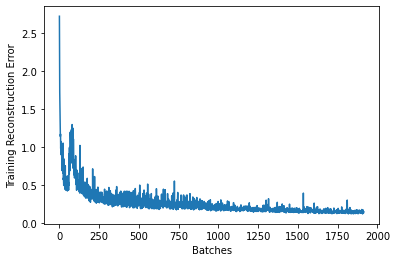

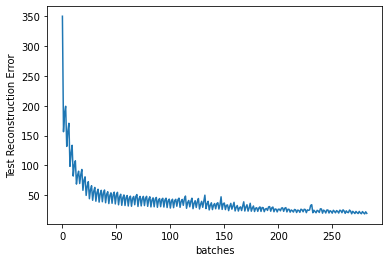

In [6]:
plt.plot(train_res_recon_error[5:])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()

plt.plot(test_res_recon_error[5:])
plt.xlabel('batches')
plt.ylabel('Test Reconstruction Error')
plt.show()

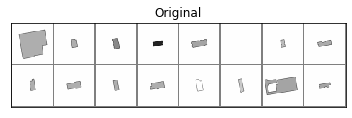

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


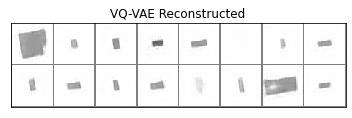

In [7]:
vqvae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals.to(device)

_, valid_recon, _ = vqvae(valid_originals)
def show(img, title):
    npimg = img.numpy()
#     print(img)
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)


show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()